In [1]:
!pip install gmpy2

In [2]:
!python --version

Python 3.10.9


In [3]:
from typing import *
from gmpy2 import *
import pyprimesieve as sieve
import math
from random import randint

In [4]:
is_prp = is_bpsw_prp
mod_inv = invert
def ilog(base, t):
    return int(math.log(t)/math.log(base))

In [5]:
class Montgomery:
    n_bit:int
    N:type[mpz]
    Nr:type[mpz]
    bit_mask:type[mpz]
    
    def __init__(self,N:type[mpz]):
        self.N = N
        self.n_bit = bit_length(N)
        self.bit_mask = bit_mask(self.n_bit)
        R = bit_set(0, self.n_bit)
        self.Nr = R - mod_inv(N, R) # N*Nr = -1 mod R (R = 2**n_bit)
    
    def iadd(self, a:type[xmpz], b:type[xmpz]):
        a += b
        if a >= self.N:
            a -= self.N
    
    def isub(self, a:type[xmpz], b:type[xmpz]):
        a -= b
        if a < 0:
            a += self.N
    
    def idbl(self, a:type[xmpz]):
        a += a
        if a >= self.N:
            a-= self.N
    
    def itrunc(self, a:type[xmpz]):
        a &= self.bit_mask
    
    def iREDC(self, T:type[xmpz])->type[xmpz]:
        tt = T[0:self.n_bit]
        m = (tt*self.Nr)[0:self.n_bit]
        T += m*self.N
        T >>= self.n_bit
        if T >= self.N:
            T -= self.N
        return T

class MontForm:
    x : type[xmpz]
    mont : type[Montgomery]
    def __init__(self, mont:type[Montgomery], x:type[mpz]):
        self.x = xmpz(x)
        self.mont = mont

    def copy(self):
        return MontForm(self.mont, self.x.copy())

    def __iadd__(self, y):
        self.mont.iadd(self.x, y.x)
        return self

    def __isub__(self, y):
        self.mont.isub(self.x, y.x)
        return self

    def __imul__(self, y):
        self.x *= y.x
        self.mont.iREDC(self.x)
        return self

    def iredc(self):
        self.mont.iREDC(self.x)
        return self

    def __add__(self, y):
        return self.copy().__iadd__(y)

    def __sub__(self, y):
        return self.copy().__isub__(y)

    def __mul__(self, y):
        return self.copy().__imul__(y)
    
    def idbl(self):
        self.mont.idbl(self.x)
        return self
    
    def iquad(self): # used in MC addition
        return self.idbl().idbl()
    
    def dbl(self):
        return self.copy().idbl()
    
    def isqr(self):
        self.__imul__(self)
        return self
    
    def sqr(self):
        return self.copy().isqr()

    def get(self):
        return self.copy().iredc().x
    
    def __repr__(self):
        return str(self.get())

Mont : TypeAlias = type[Montgomery]
MF : TypeAlias = type[MontForm]
_mpz : TypeAlias = type[mpz]
def MakeMF(mont:Mont , x:_mpz)->MF:
    return MontForm(mont, f_mod(x<<mont.n_bit, mont.N))

def MF1(mont:Mont)->MF: # Get the montgomery form of 1
    return MontForm(mont, mpz(1<<mont.n_bit)-mont.N)

In [120]:
def pollard_rho(n, b = mpz(1)):
    mont = Montgomery(n)
    x = MakeMF(mont, mpz(2))
    b = MakeMF(mont, b)
    y = x.copy()
    d = mpz(1)
    q = 1
    
    ngcd = 0
    while d == 1:
        for i in range(q):
            x *= x
            x += b
            d = gcd((x-y).x, n)
            ngcd += 1
            if d != 1:
                return d, ngcd
        y=x.copy()
        q <<= 1


In [122]:
def pollard_rho_opt(n, b = mpz(1), k:int = 5):
    mont = Montgomery(n)
    x = MakeMF(mont, mpz(2))
    b = MakeMF(mont, b)
    y = x.copy()
    d = mpz(1)
    q = 1
    v, acc = None, 0
    ngcd = 0
    while d == 1:
        for i in range(q):
            x *= x
            x += b
            if acc == 0:
                v = x-y
            else:
                v*= x-y
            acc += 1
            if acc >> k:
                acc = 0
                ngcd += 1
                d = gcd(v.x, n)
                if d != 1:
                    return d, ngcd
        y=x.copy()
        q <<= 1


In [124]:
%time pollard_rho_opt(mpz(2072029919795747597891215229))

CPU times: total: 49.8 s
Wall time: 49.8 s


(mpz(43407899554997), 411399)

In [125]:
%time pollard_rho(mpz(2072029919795747597891215229))

CPU times: total: 34.2 s
Wall time: 34.2 s


(mpz(43407899554997), 13164760)

In [7]:
def MF_Exp(a:MF, x:MF, e:int)->MF:
    x = x.copy()
    while e:
        if e&1:
            a *= x
        e >>=1
        if e:
            x *= x
    return a

In [8]:
class PollardP1:
    sieve: list[int]
    plim: int
    upn: int
    def __init__(self, upn:int = int(1e6)):
        self.sieve = sieve.primes(upn)
        self.plim = upn
        self.upn = upn
    
    def up(self):
        self.sieve += sieve.primes(self.plim, self.plim + self.upn)
        self.plim += self.upn
    
    def P1(self, n:_mpz, B1:int = 1000, B2:int = int(1e6)):
        # Pollard's P-1 method can only factor Ps with smooth P-1
        # but if it hits then is really fast
        pi = 0
        mont = Montgomery(n)
        a = MakeMF(mont, 2)
        c1 = MakeMF(mont, 1) # constant for 1 in montgomery form
        # Stage 1
        while self.sieve[pi] <= B1:
            q = self.sieve[pi]
            tq = q*q
            while tq <= B2:
                tq *= q
            if q == 2:
                a = MF_Exp(c1.copy(), a, tq)
            else:
                a = MF_Exp(a, a, tq-1) # saves a mul
            u = gcd((a-c1).x, n)
            if u > 1:
                return u
            pi+=1
            if pi >= len(self.sieve):
                self.up()
        # Stage 2
        q = c1.copy()
        h = a.copy()
        h = MF_Exp(h, h, self.sieve[pi]-1)
        a1=[a*a]
        while self.sieve[pi] <= B2:
            p = self.sieve[pi]
            q *= (h-c1)
            u = gcd(q.x, n)
            if u > 1:
                return u
            pi+=1
            if pi >= len(self.sieve):
                self.up()
            dp = self.sieve[pi] - p
            qp = (dp-2)>>1
            while len(a1) <= qp:
                a1.append(a1[0]*a1[-1])
            h *= a1[qp]
        # failed
        return 1

Following Pollard's P-1 algorithm here we will implement the Lenstra's Elliptic Curve Method, with following specifications:

1. Stage 1: Use Montgomery curve and differential chain, with Suyama parametrization, see https://eprint.iacr.org/2017/212.pdf
2. Stage 2: Curve is converted to short Weierstrass curves under projective coordinates
3. Since we don't have to care about inversions, so we can use Montgomery form for modular multiplication
4. Stage 2 use regular p_iP -> p_i+1P, not BSGS optimization

In theory all invert cases should be handled with care since there's a probability of failure by dividing 0, but this only happens when it immediately gets a factor of N, so is extremely rare. (And lucky if handled)

In [9]:
global_randstate = random_state()

class MontCurve:
    mont: Mont
    N: _mpz
    A: _mpz
    B: _mpz
    A2d4: MF # constant for (A+2)/4
    Ad: MF # constant for 2A
    Bd: MF # constant for 2B
        
    P1: tuple[MF, MF, MF]
    def __init__(self, N: _mpz):
        sigma = mpz_random(global_randstate,N)
        while sigma in {mpz(0),mpz(1),N-1,mpz(5)}:
            sigma = mpz_random(global_randstate,N)
        
        u = (sigma*sigma - 5)%N
        v = (sigma<<2)%N
        q = (v-u)%N
        u2 = u*u%N
        u3 = u*u2%N
        v2 = v*v%N
        v3 = v*v2%N
        A = (q*q%N*q%N*(3*u+v)%N * invert(4*u3*v%N,N)-2)%N
        """
        u = s^2-5, v = 4*s,
        A = (v-u)^3*(3*u+v)/(4*u^3*v)-2,
        x0=u^3/v^3.
        """
        x = u3*invert(v3,N)%N
        # let y = 1, then B = x^3+Ax^2+x
        B = x*((x+A)*x%N+1)%N
        
        self.A = A
        self.B = B
        self.N = N
        self.mont = Montgomery(N)
        
        mont = self.mont
        
        A2d4 = (A+2)*invert(4,N) % N

        self.A2d4 = MakeMF(self.mont, A2d4)
        self.Ad = MakeMF(self.mont, A<<1)
        self.Bd = MakeMF(self.mont, B<<1)
        
        self.P1 = (MakeMF(self.mont, x) ,MF1(self.mont), MF1(self.mont))
        
    
    def to_Weierstrass(self, point: tuple[MF, MF]): 
        # convert a point on the Montgomery curve onto equivalent weierstrass curve
        # (x,y) in affine coordinates, not (x,z) of regular montgomery coordinates
        B = MakeMF(self.mont, self.B)
        dB = B.copy()
        dB *= dB
        x,y = point
        A3 = MakeMF(self.mont, self.A * invert(3,self.N)%self.N)
        B *= x + A3
        dB *= y
        return (B,dB)
    
    def xAdd(self, P:tuple[MF,MF], Q:tuple[MF,MF], D:tuple[MF,MF]):
        # D = P-Q
        XP, ZP=P
        XQ, ZQ=Q
        XD, ZD=D # ZD = 1
        V0 = XP + ZP
        V1 = XQ - ZQ
        V1 *= V0
        V0 = XP - ZP
        V2 = XQ + ZQ
        V2 *= V0
        V3 = V1 + V2
        V3 *= V3
        V4 = V1 - V2
        V4 *= V4
        return (V3, V4*XD)
    
    def xDbl(self, P:tuple[MF,MF]):
        XP, ZP = P
        V1 = XP + ZP
        V1 *= V1
        V2 = XP - ZP
        V2 *= V2
        X2P = V1*V2
        V1 -= V2
        V3 = self.A2d4 * V1
        V3 += V2
        Z2P = V1 * V3
        return (X2P, Z2P)
    
    def Ladder(self, P:tuple[MF, MF], k:int):
        # P in form (x,z), but z=1
        # returns (kP, (k+1)P)
        b1 = k.bit_length() - 1
        XP, ZP = P
        x0 = XP.copy(), ZP.copy()
        x1 = self.xDbl(x0)
        while b1:
            # print(f"P {P}, x0 {x0}, x1 {x1}")
            b1 -= 1
            if k&(1<<b1):
                # print("k=1")
                x0, x1 = self.xAdd(x0,x1,P),self.xDbl(x1)
            else:
                # print("k=0")
                x0, x1 = self.xDbl(x0), self.xAdd(x0,x1,P)
        # print(f"Ladder {k}:")
        # print(f"from P={P} to kP={x0}, k+1P={x1}")
        return x0,x1
    
    def scale(self, A:tuple[MF,MF,MF]):
        # A:(x,y,z) -> A'(x/z,y/z,1)
        # return (A', gcd(z,N))
        x,y,z = A
        zt = z.get()
        g,s,t = gcdext(zt,self.N)
        if g > 1:
            return ((), g)
        else:
            # s is inverse of z
            sf = MakeMF(self.mont, s)
            return ((x*sf, y*sf, MF1(self.mont)),1)
    
    def recover(self, P:tuple[MF,MF], Q:tuple[MF,MF], Qp:tuple[MF,MF]):
        # P in representation (x,y,z) with z=1 (omitted)
        # Q = kP, Qp = (k+1)P, recover (x,y,1) of Q
        # if z can't be inverted then a factor is found
        xp, yp = P
        XQ, ZQ = Q
        XA, ZA = Qp
        v1 = xp*ZQ
        v2 = XQ+v1
        v3 = XQ-v1
        v3*= v3
        v3*= XA
        v1 = self.Ad * ZQ
        v2+= v1
        v4 = xp*XQ
        v4+= ZQ
        v2*= v4
        v1*= ZQ
        v2-= v1
        v2*= ZA
        Yp = v2-v3
        v1 = self.Bd * yp
        v1*= ZQ
        v1*= ZA
        Xp = v1*XQ
        Zp = v1*ZQ
        
        return self.scale((Xp,Yp,Zp))
        
class WeiCurve:
    mont: Mont
    N: _mpz
    A: _mpz
    B: _mpz
    a: MF
    b: MF
    # b3:MF
    def __init__(self, mc: type[MontCurve]):
        self.N = mc.N
        self.mont = mc.mont
        
        N = mc.N
        A = mc.A
        B = mc.B
        
        A3 = A*invert(3,N)%N
        Bs = B*B%N
        Bc = B*Bs%N
        self.A = Bs * ((1-A*A3)%N)%N # B^2(1-A^2/3)
        self.B = Bc*A3%N * (2*A3*A3%N - 1)%N # B^3A/3(2A^2/9-1)
        self.a = MakeMF(self.mont, self.A)
        self.b = MakeMF(self.mont, self.B)
        # self.b3 = self.b.copy()
        # self.b3.idbl()
        # self.b3+=self.b
    """ Not used because in all cases we can reduce to add1
    def add(self, A:tuple[MF,MF,MF], B:tuple[MF,MF,MF]):
        # add in projective coordinates
        X1,Y1,Z1 = A
        X2,Y2,Z2 = B
        a = self.a
        b = self.b
        b3= self.b3
        t0 = X1*X2
        t1 = Y1*Y2
        t2 = Z1*Z2
        t3 = X1+Y1
        t4 = X2+Y2
        t3*= t4
        t4 = t0+t1
        t3-= t4
        t4 = X1+Z1
        t5 = X2+Z2
        t4*= t5
        t5 = t0+t2
        t4-= t5
        t5 = Y1+Z1
        X3 = Y2+Z2
        t5*= X3
        X3 = t1+t2
        t5-= X3
        Z3 = a*t4
        X3 = b3*t2
        Z3+= X3
        X3 = t1-Z3
        Z3+= t1
        Y3 = X3*Z3
        t1 = t0+t0
        t1+= t0
        t2 = a*t2
        t4*= b3
        t1+= t2
        t2 = t0-t2
        t2*= a
        t4+= t2
        t0 = t1*t4
        Y3+= t0
        t0 = t5*t4
        X3*= t3
        X3-= t0
        t0 = t3*t1
        Z3*= t5
        Z3+= t0
        return (X3,Y3,Z3)
    """
    
    def add1(self, A:tuple[MF,MF,MF], B:tuple[MF,MF,MF]):
        # Z2 = 1
        X1,Y1,Z1 = A
        X2,Y2,Z2 = B
        u = Y2*Z1-Y1
        uu = u*u
        v = X2*Z1-X1
        vv = v*v
        vvv = v*vv
        R = vv*X1
        A = uu*Z1-vvv-R.dbl()
        X3 = v*A
        Y3 = u*(R-A)-vvv*Y1
        Z3 = vvv*Z1
        return X3,Y3,Z3
    
    def dbl(self, A:tuple[MF,MF,MF]):
        # dbl in projective coordinates
        X1,Y1,Z1 = A
        XX = X1.sqr()
        ZZ = Z1.sqr()
        a = self.a
        
        XX3 = XX.dbl()
        XX3 += XX
        
        w = a*ZZ+XX3
        s = Y1*Z1
        s.idbl()
        ss = s.sqr()
        sss = s*ss
        R = Y1*s
        RR = R.sqr()
        B = (X1+R).isqr()-XX-RR
        h = w.sqr()-B.dbl()
        X3 = h*s
        Y3 = w*(B-h)-RR.dbl()
        Z3 = sss
        return (X3,Y3,Z3)
    
    def scale(self, A:tuple[MF,MF,MF]):
        # A:(x,y,z) -> A'(x/z,y/z,1)
        # return (A', gcd(z,N))
        x,y,z = A
        zt = z.get()
        g,s,t = gcdext(zt,self.N)
        if g > 1:
            return ((), g)
        else:
            # s is inverse of z
            sf = MakeMF(self.mont, s)
            return ((x*sf, y*sf, MF1(self.mont)),1)
    
    def xpow(self, A:tuple[MF,MF,MF], e:int):
        # A should be scaled, i.e. (x,y,1)
        # print(f"xpow {A}^{e}")
        x,y,z = A
        res = x.copy(), y.copy(), z.copy()
        if e>1:
            for b in range(e.bit_length()-2, -1, -1):
                # print(f"at bit {b} with existence {e&(1<<b)}")
                res = self.dbl(res)
                if e & (1<<b):
                    res = self.add1(res, A)
                    
            return res
        else:
            return res

In [234]:
def factor_curve(mc:type[MontCurve], B1: int = 3000, B2: int = int(1e6), primeBlock = int(1e6), S1Accum:int = int(1e15)):
    # generate primes with a block sieve (not on the bottleneck)
    primes, uplimit, nowp = sieve.primes(primeBlock),primeBlock,0
    def newp():
        primes, uplimit, nowp =sieve.primes(uplimit, uplimit+primeBlock),uplimit+primeBlock,0
    # Stage 1
    xp, yp, c1 = mc.P1
    accum = 1
    # print((xp,yp,c1))
    while primes[nowp] <= B1:
        accum *= primes[nowp] ** ilog(primes[nowp], B1)
        if accum >= S1Accum:
            p0, p1 = mc.Ladder((xp,c1), accum)
            rest, fact = mc.recover((xp,yp),p0,p1)
            # print(rest,fact)
            if fact > 1:
                return fact
            else:
                xp, yp, c1 = rest
            accum = 1
        nowp += 1
        if nowp >= len(primes):
            newp()
    if accum > 1:
        p0, p1 = mc.Ladder((xp,c1), accum)
        rest, fact = mc.recover((xp,yp),p0,p1)
        if fact > 1:
            return fact
        else:
            xp, yp, c1 = rest
    # Stage 2
    # Step 1: convert montgomery curve into weierstrass curve
    wc = WeiCurve(mc)
    xp, yp = mc.to_Weierstrass((xp,yp))
    # Step 2: build jump list
    # jump with interval of 2n
    # so first jump is 2P
    # we want to enforce all entries in jump list has z = 1
    # so we can just use add1
    # jump list has a max interval of roughly O(log^2 n) (prime interval)
    # so it is sufficiently small that we can normalize all jump points
    j1, fact = wc.scale(wc.dbl((xp, yp, c1)))
    if fact > 1:
        return fact
    jump = [j1]
    def get_jump(interval: int):
        iidx = (interval - 2) >> 1
        while iidx >= len(jump):
            last = jump[-1]
            fst = jump[0]
            nlst, fact = wc.scale(wc.add1(last, fst))
            if fact > 1:
                return nlst, fact
            jump.append(nlst)
        return jump[iidx], 1
    # print(f"Entering S2, H = {(xp,yp,c1)}")
    xa, ya, za = wc.xpow((xp, yp, c1), primes[nowp])
    while primes[nowp] <= B2:
        pp = primes[nowp]
        u = gcd(za.x, mc.N)
        if u>1:
            return u
        nowp += 1
        if nowp >= len(primes):
            newp()
        if primes[nowp] <= B2:
            jn, fact = get_jump(primes[nowp]-pp)
            if fact > 1:
                return fact
            xa, ya, za = wc.add1((xa,ya,za), jn)
    return 1 # failed

def ECM_Factor(
    n:_mpz, curves:int = 50 , B1: int = 3000, B2: int = int(1e6),
    primeBlock = int(1e6), S1Accum:int = int(1e15)):
    for i in range(curves):
        curve = MontCurve(n)
        fac = factor_curve(curve, B1, B2, primeBlock, S1Accum)
        if fac != 1 and fac != n:
            print(f"used {i} curves")
            return fac
    return 1

In [264]:
def ECM_Factor_WithParametrization(n:_mpz):
    exp = math.exp
    log = math.log
    sqrt = math.sqrt
    nl = log(n) / 2 # p
    least = math.inf
    bb, b2, uux = 0, 0, 0
    for i in range(40,60):
        for c in range(150,180):
            ii = i/100
            cc = c/100
            b = sqrt(nl*log(nl)*ii)
            u = nl / b
            B = exp(b)
            uu = u**u / (u**cc * log(u)**(cc-1))
            
            if (B + B**cc/log(B**cc)/2)*uu < least:
                least = (B**cc/log(B**cc)/2)*uu
                bb, b2, uux = B, B**cc, uu
    
    B1, B2, nCurves = int(bb*7), int(b2*15), int(uux)
    print(B1, B2, nCurves)
    return ECM_Factor(n, curves = nCurves, B1=B1, B2=B2)

In [265]:
%time ECM_Factor_WithParametrization(test_suite[15])

6448 419407 164
used 49 curves
CPU times: total: 10.5 s
Wall time: 10.5 s


mpz(339017957045771)

In [262]:
test_suite[18].bit_length()

106

Here we present two algorithms of the congruence of squares method.

1. Continued fraction method
2. Quadratic sieve (specifically, Self-Initializing Quadratic Sieve)

Congruence of squares methods factor integers by finding relations of $a^2 \equiv b^2 \pmod n$, they don't do this by searching randomly, but by constructing square on the right side with sufficiently many known factorizations of $(a^2 \bmod n)$. For those algorithms, linear algebra on $\mathbf{GF}(2)$ is a common need, which won't be presented and we'll just use an already implemented block lanczos method instead.

In [11]:
# https://github.com/SebWouters/blanczos
'''
    blanczos: block lanczos for gf(2)

    Copyright (c) 2020, Sebastian Wouters
    All rights reserved.

    This file is part of blanczos, licensed under the BSD 3-Clause License.
    A copy of the License can be found in the file LICENSE in the root
    folder of this project.
'''
import numpy
import ctypes
libblanczos = ctypes.cdll.LoadLibrary('./blanczos.dll')

libblanczos.blanczos.argtypes = [numpy.ctypeslib.ndpointer(ctypes.c_uint, flags="C_CONTIGUOUS"),
                                 ctypes.c_ulonglong,
                                 ctypes.c_uint,
                                 ctypes.c_uint,
                                 numpy.ctypeslib.ndpointer(ctypes.c_ulonglong, flags="C_CONTIGUOUS")]
libblanczos.blanczos.restype = ctypes.c_uint

def blanczos(B, N, Nrow, Ncol):
    result = numpy.zeros([Ncol], dtype=ctypes.c_ulonglong)
    Nsol = libblanczos.blanczos(B, N, Nrow, Ncol, result)
    return (Nsol, result)



In [100]:
class CongruenceSolver:
    primes: list[int]
    primelut: list[int] # a lut to check the smallest factor of any number <= B2,
    # used to speed up factorization of smooth number.
    prime_to_row: list[int] # conversion from prime to row number, i.e. nth prime
    B1: int
    B2: int
    nrow: int # Number of primes <= B1
    ncol: int # Number of relations
    ncol_need: int # Number of relations needed to solve the equation;
    # Defined as Nrow + EC, where EC is a small constant to improve the probability of finding a solution
    matrix: list[int] # sparse
    full: list[tuple[_mpz, dict[int,int]]]
    # store a and factors of b for a^2 = b (mod N) that b is smooth.
    partial: dict[int, tuple[_mpz, list[tuple[int,int]]]]
    # f -> (a, factors u^e:(u,e) of b) for a^2 = bf (mod N) where f is a prime
    # within (B1,B2], when two partial relations has the same f then they can combine into a full relation
    N: _mpz # the number to factor
    allow_neg: bool
    # allowing negative (-1 as a base)
    # useful in cfrac
    primebase: list[int]
    pbset: set[int]
    existing: set[_mpz]
    setmat: dict[tuple[int,int],tuple[int,int]]
    def __init__(self, N: _mpz, B1Primes:list[int], B1: int, B2: int, EC: int = 32):
        self.primes = sieve.primes(B2)
        self.primelut=[i for i in range(B2+1)]
        self.prime_to_row = [0 for i in range(B1+1)]
        for i in self.primes:
            for j in range(i*2, B2+1, i):
                self.primelut[j] = min(self.primelut[j], i)
        
        self.matrix = []
        self.full = []
        self.partial = {}
        self.existing = set()
        self.setmat = {}
        
        self.B1 = B1
        self.B2 = B2
        
        acc = 0
        for i in B1Primes:
            if i != -1:
                self.prime_to_row[i] = acc
            acc+=1

        
        self.nrow = len(B1Primes)
        if B1Primes[0] == -1:
            self.allow_neg = True
            B1Primes = B1Primes[1:]
        else:
            self.allow_neg = False
        
        self.primebase = B1Primes
        self.pbset = set(B1Primes)

        self.ncol = 0
        self.ncol_need = self.nrow + EC
        
        self.N = N
    
    def set_matrix(self, idx:tuple[int, int], a:int, i:int):
        if idx in self.setmat:
            print(idx,self.setmat[idx])
            print(a,i)
            raise Exception("what")
        else:
            self.setmat[idx]=(a,i)
    
    def prdict(self, ep:dict[int,int]):
        return " * ".join([f"{x}^{ep[x]}" for x in ep])
    
    def add_relation(self, a: _mpz, pf:dict[int, int]):
        #print(f"Add relation: {a}^2 = {self.prdict(pf)}")
        if a in self.existing:
            return self.ncol
        self.existing.add(a)
        self.full.append((a,pf))
        for i in pf:
            if pf[i]&1:
                row = self.prime_to_row[i] if i != -1 else 0
                self.matrix.append(row) # row
                self.matrix.append(self.ncol) # column
                # self.set_matrix((self.prime_to_row[i], self.ncol),int(a),i)
        self.ncol += 1
    
    def add_partial_relation(self, a: _mpz, f: int, pf:dict[int, int]):
        # return # don't use partial relation
        # print(f"Add partial relation: {a}^2 = [{f}] * {self.prdict(pf)}")
        
        if f in self.partial:
            b, plist = self.partial[f]
            if a!=b:
                br = a*b%self.N*invert(f,self.N)%self.N
                for (u,e) in plist:
                    if u in pf:
                        pf[u]+= e
                    else:
                        pf[u] = e
                self.add_relation(br,pf)
        else:
            pf2list = [(x,pf[x]) for x in pf if pf[x]]
            self.partial[f] = (a,pf2list)
    
    def evaluate_dict(self, d:dict[int,int]):
        a = mpz(1)
        for i in d:
            a = a*powmod(i, d[i], self.N)%self.N
        return a
    
    def try_add_relation(self, a: _mpz, b: _mpz, pf:dict[int, int] = None):
        # check and try add relation on a^2 = b*E(pf) (mod n).
        # used for QS where b is partially factored when sieving
        # E(pf) = \prod f->e \in pf. f^e
        
        # Probably only useful for cfrac, since it's approximation can be negative
        if not pf:
            pf = {}
            
        if a in self.existing:
            return self.ncol
        
        """
        ub = abs(b) * self.evaluate_dict(pf)
        if (math.log(abs(a))*2 - math.log(ub)) < 0.1:
            return self.ncol# throw away the trivial cases
        """
        
        if self.allow_neg:
            if b < 0:
                b = -b
                pf[-1] = 1
            else:
                ne = self.N - b
                if ne < b:
                    b = ne
                    pf[-1] = 1
        
        B1 = self.B1
        B2 = self.B2
        for i in self.primebase:
            quot, rem = f_divmod(b,i)
            if rem == 0:
                if i not in pf:
                    pf[i]=0
            while rem == 0:
                pf[i]+=1
                b = quot
                quot, rem = f_divmod(b,i)
            if b <= B2:
                break
        # print(f"relation: {a}^2 = rem * {self.prdict(pf)}")
        # print(f"Remaining factor {b}")
        if b > B2: # factorization failed
            return self.ncol
        b = int(b)
        remfactor = 1 # remainder factors that not in prime base
        while b != 1:
            factor = self.primelut[b]
            if factor in self.pbset:
                if factor in pf:
                    pf[factor]+=1
                else:
                    pf[factor]=1
            else:
                remfactor *= factor
            b //= factor
        if remfactor == 1:
            self.add_relation(a, pf)
        else:
            self.add_partial_relation(a, remfactor, pf)
        return self.ncol
    
    def evaluate_dict_sqrt(self, d:dict[int,int]):
        a = mpz(1)
        for i in d:
            a = a*powmod(i, d[i]>>1, self.N)%self.N
        return a
    
    def evaluate_congruence(self, e:list[int]):
        a = mpz(1)
        b:dict[int,int] = {}
        # print(f"Check solution: {[1 if x else 0 for x in e[:self.ncol]]}")
        for i in range(self.ncol):
            if e[i]:
                al, ed = self.full[i]
                a = a*al%self.N
                for j in ed:
                    if j in b:
                        b[j]+=ed[j]
                    else:
                        b[j]=ed[j]
        be = self.evaluate_dict_sqrt(b)
        # print(f"should be {a}^2 - {be}^2")
        u = gcd(a+be,self.N)
        if 1 < u < self.N:
            return u
        return gcd(a-be, self.N)
    
    def solve_congruence(self, attempts = 100):
        B = numpy.array(self.matrix, dtype=ctypes.c_uint)
        nrow = self.nrow
        ncol = max(nrow+64, self.ncol)
        nsol, result = blanczos(B, len(B)//2, nrow, ncol)
        for i in range(attempts):
            ares = [0 for x in result]
            rbit = mpz_urandomb(global_randstate, nsol)
            while rbit:
                lb = rbit & (-rbit)
                rbit ^= lb
                for i in range(self.ncol):
                    qi = 1 if result[i] & lb else 0
                    ares[i] ^= qi
            u = self.evaluate_congruence(ares)
            if u != 1 and u != self.N:
                return u
        return mpz(1)
    
    def __repr__(self):
        res = ""
        res += (f"Factoring {self.N}") + "\n"
        res += (f"B1: {self.B1}") + "\n"
        res += (f"Prime base: {self.primebase}") + "\n"
        for (a, ep) in self.full:
            res += (f"{a}^2 = {self.prdict(ep)}") + "\n"
        return res

In [13]:
def cfrac_b_est(n:_mpz):
    n = float(int(n))
    return int(math.exp(math.sqrt(math.log(n)*math.log(math.log(n)))/2))

In [14]:
def cfracPrimebase(n:_mpz, k:int, B1: int):
    # generate prime base, soley consists of all prime factors that are quadratic residue with kn
    # that <= B1
    n = n*k
    pb = [-1,2]
    primes = sieve.primes(B1)
    for pi in primes:
        if pi > 2 and jacobi(n, pi) >= 0:
            pb.append(pi)
    return pb

In [174]:
def cfrac_factor(N:_mpz, k:int = 1,B2_factor:float = 32.0, B1:int = 0,EC=0):
    if B1 == 0:
        B1 = cfrac_b_est(N)
    B2 = int(max(B2_factor, 1.0)*B1)
    primeBase = cfracPrimebase(N,k,B1)
    csolve = CongruenceSolver(N, primeBase, B1, B2, EC)
    
    n = N*k
    x = isqrt(n)
    y,z,w = x, mpz(1), x+x
    r = w
    f1, f2 = mpz(1), x
    q = 1
    while csolve.ncol < csolve.ncol_need:
        y = r*z - y
        z = (n-y*y)//z
        r = (x+y)//z
        f1, f2 = f2, (r*f2+f1)%n
        if is_square(z):
            g = gcd(f1 - isqrt(z), N)
            if g>1 and g<N:
                return g
        
        q ^= 1
        if z > 1:
            csolve.try_add_relation(f1,z if q else -z)
        if z == 1:
            return 1
    if csolve.ncol >= csolve.ncol_need:
        # print(csolve)
        # return csolve
        return csolve.solve_congruence()
    else:
        return 1

In [175]:
cfrac_factor(test_suite[0])

mpz(62986545619)

{a:1}

In [16]:
def sqmodp(n:_mpz, p:int):
    # p : prime
    n = int(n%p)
    if p == 2:
        return n&1
    if jacobi(n,p) < 1:
        return 0
    if p&3 == 3:
        return pow(n,p+1>>2,p)
    q,s = p-1,0
    while (q&1)==0:
        q = q>>1
        s += 1
    for z in range(2,p-1):
        if jacobi(z,p) < 1:
            m,c,t,r = s,pow(z,q,p),pow(n,q,p),pow(n,(q+1)>>1,p)
            while True:
                if t == 0:
                    return 0
                i = 0
                u = t
                while u != 1:
                    u = u*u%p
                    i+=1
                if i == 0:
                    return r
                if i == m:
                    return 0
                b = pow(c,2**(m-i-1),p)
                m,c = i,b*b%p
                t,r = t*c%p,r*b%p

In [101]:
class primeg:
    primes: list[int]
    ptr: int
    upl: int
    blk: int
    def __init__(self, block = int(1e5)):
        self.primes = sieve.primes(block)
        self.blk = block
        self.ptr = 0
        self.upl = block
    
    def get(self):
        if self.ptr < len(self.primes):
            self.ptr += 1
            return self.primes[self.ptr-1]
        else:
            self.ptr = 1
            self.primes = sieve.primes(self.upl, self.upl+self.blk)
            self.upl += self.blk
            return primes[0]

class SFac:
    p: int
    t: int
    log: int
    soln1: _mpz
    soln2: _mpz
    ainv: int
    def __init__(self, p, t, log):
        self.p = p
        self.t = t
        self.log = log
        self.soln1 = None
        self.soln2 = None
        self.ainv = None

_sfac : TypeAlias = type[SFac]

class QSPoly:
    coeff:list[_mpz]
    a:_mpz
    b:_mpz
    def __init__(self, coeff:list[_mpz], a:_mpz = None, b:_mpz = None):
        self.coeff = coeff
        self.a = a
        self.b = b
    
    def eval(self, x:_mpz):
        ret = mpz(0)
        for i in self.coeff:
            ret = ret*x + i
        return ret

_spol : TypeAlias = type[QSPoly]

class SIQS:
    params: dict[str, int]
    def __init__(self, params: dict[str, int] = {}):
        default = {
            "trail_division_eps" : 25,
            "poly_min_prime" : 400,
            "poly_max_prime" : 4000,
            "smallest_sieve_prime" : 50,
            "sieve_eps": 70,
            "verbose": 0,
            "extra_ratio": 0.03,
            "a_expect_factor": 5.4
        }
        for i in default:
            if i not in params:
                params[i]=default[i]
        self.params = params
    
    def log(self, st, verbose = 0):
        if self.params["verbose"]>verbose:
            print(st)
    
    def generate_factor_base(self, N: _mpz, nf: int)->list[_sfac]:
        factor_base:list[_sfac] = []
        ps = primeg()
        while len(factor_base) < nf:
            p = ps.get()
            t = sqmodp(N,p)
            if t == 0:
                continue
            factor_base.append(SFac(p, t, round(math.log(p)*4)))
        return factor_base
    
    def create_poly(self, a:_mpz, b:_mpz, N: _mpz, factor_base: list[_sfac], first: bool):
        b_or = b
        if 2*b > a:
            b = a-b
        
        g = QSPoly([a*a, 2*a*b, b*b-N], a, b_or)
        h = QSPoly([a,b])
        
        for fb in factor_base:
            if a % fb.p == 0:
                continue
            if first:
                fb.ainv = invert(a, fb.p)
            fb.soln1 = ((fb.ainv*(fb.t-b))%fb.p)
            fb.soln2 = ((fb.ainv*(-fb.t-b))%fb.p)
        
        return g,h
    
    def init_first_poly(self, N: _mpz, m: int, factor_base: list[_sfac]) -> tuple[_spol, _spol, list[_mpz]]:
        log = math.log
        
        target0 = (log(N) + log(2))/2 - log(m) # log(sqrt(2N)/M)
        
        pTarget = exp(target0 / self.params["a_expect_factor"])
        tTarget = self.params["poly_min_prime"] + self.params["poly_max_prime"] >> 1
        lim_factor = 1
        if pTarget < tTarget:
            lim_factor = pTarget / tTarget
        
        max_factor = factor_base[-1].p
        upper_lim = int(self.params["poly_max_prime"] * lim_factor)
        lower_lim = int(self.params["poly_min_prime"] * lim_factor)
        self.log(f"Limits: [{lower_lim},{upper_lim}]")
        upper, lower = 0, len(factor_base)
        for i in range(len(factor_base)):
            if factor_base[i].p >= lower_lim:
                lower = min(lower, i)
            if factor_base[i].p <= upper_lim:
                upper = max(upper, i)
        
        
        target1 = (target0 - log(factor_base[lower].p + factor_base[upper].p >> 1)/2)
        
        target0 *= 4
        target1 *= 4
        
        best_q, best_a, best_ratio = None, None, None
        
        for i in range(30):
            A = mpz(1)
            lA = 0
            Q = {}
            while lA < target1:
                pi = 0
                while pi == 0 or pi in Q:
                    pi = randint(lower,upper)
                fb = factor_base[pi]
                A, lA = A*fb.p, lA+fb.log
                Q[pi]=fb
            
            ratio = math.exp((lA - target0)/4)
            
            if not best_q or (0.9 <= ratio < best_ratio) or (ratio > best_ratio < 0.9):
                best_q, best_a, best_ratio = Q, A, ratio
        
        a,b = best_a, 0
        
        arr = []
        qs = []
        
        for i in best_q:
            fb = best_q[i]
            p, r = fb.p, a//fb.p
            qs.append(p)
            
            g = fb.t * invert(r, p) % p
            if g > (p>>1):
                g = p-g
            t = r*g
            b += t
            arr.append(t)
        
        g, h = self.create_poly(a, b, N, factor_base, True)
        return g,h,arr,qs
    
    def next_poly(self, N: _mpz, factor_base: list[_sfac], i:int, g:_spol, arr: list[_mpz]):
        lb = i & (-i)
        v = lb.bit_length() - 1
        z = 2 if i & (lb<<1) else -2
        a = g.a
        b = (g.b + z*arr[v])%a
        return self.create_poly(a, b, N, factor_base, False)
    
    def siqs_sieve(self, factor_base:list[_sfac], m: int):
        sieve = numpy.zeros(2*m+1, dtype = ctypes.c_int32)
        ssp = self.params["smallest_sieve_prime"]
        for fb in factor_base:
            if fb.p >= ssp and fb.soln1:
                p, lp = fb.p, fb.log
                start_1 = fb.soln1 - (m+fb.soln1)//p * p
                start_2 = fb.soln2 - (m+fb.soln2)//p * p
                sieve[start_1+m::p] += lp
                sieve[start_2+m::p] += lp
        return sieve
    
    def calc_range(self, N: _mpz)->int:
        exp = math.exp
        sqrt = math.sqrt
        log = math.log
        ln = log(N)
        return round(exp(sqrt(ln * log(ln))/2))
    
    def calc_basesize(self, N: _mpz)->int:
        exp = math.exp
        sqrt = math.sqrt
        log = math.log
        ln = log(N)
        return round(exp(sqrt(ln*log(ln)))**(sqrt(2)/4))
    
    def factorize(self, N: _mpz):
        nf = self.calc_basesize(N)
        m = self.calc_range(N)
        
        factor_base = self.generate_factor_base(N,nf)
        factors = [-1] + [i.p for i in factor_base]
        
        B1 = factors[-1]
        B2 = B1 * 64
        
        csolver = CongruenceSolver(N, factors, B1, B2, int(len(factors)*self.params["extra_ratio"])) # 3.3% extra relations
        
        self.log("Stage 1: Sieving")
        self.log(f"sieve range m = {m}")
        self.log(f"factor base size = {nf} (+1 negation)")
        self.log(f"need est. {csolver.ncol_need} full relations")
        
        g, h, arr, i_poly, afact = None, None, None, 0, None
        sieved = 0
        while csolver.ncol < csolver.ncol_need:
            if not i_poly:
                g, h, arr, afact = self.init_first_poly(N, m, factor_base)
                self.log(f"initialized poly with a={g.a}, factors={afact}")
                self.log(f"diagnostic {sieved}, {csolver.ncol}")
            else:
                g, h = self.next_poly(N, factor_base, i_poly, g, arr)
            
            i_poly += 1
            if i_poly >= 1<<len(arr):
                i_poly = 0
            
            sieve = self.siqs_sieve(factor_base, m)
            limit = round((math.log(m)+math.log(N)/2)*4) - self.params["sieve_eps"]
            for i in range(2*m+1):
                if sieve[i] >= limit:
                    sieved += 1
                    x = i-m
                    gx = g.eval(x) // g.a
                    u = h.eval(x)
                    a_dict = {int(i):1 for i in afact}
                    if csolver.try_add_relation(u,gx,a_dict) >= csolver.ncol_need:
                        break
        self.log(f"Sieved out {sieved} entries for {csolver.ncol} relations")
        return csolver.solve_congruence(attempts=20)


In [70]:
siqs = SIQS({"verbose":1, "sieve_eps":70})

In [21]:
%time siqs.factorize(mpz(4822281101541390286757406699164689547364479213)).solve_congruence(attempts = 20)

Stage 1: Sieving
sieve range m = 63896
factor base size = 2500 (+1 negation)
need est. 2584 full relations
Limits: [400,4000]
initialized poly with a=2114087668535397479, factors=[547, 1867, 521, 883, 2633, 1709]
diagnostic 0, 0
Limits: [400,4000]
initialized poly with a=1676422012852591237, factors=[757, 467, 677, 3769, 1409, 1319]
diagnostic 833, 94
Limits: [400,4000]
initialized poly with a=3153877687404488179, factors=[521, 1061, 1231, 941, 3851, 1279]
diagnostic 1744, 198
Limits: [400,4000]
initialized poly with a=2449758084060398159, factors=[821, 1171, 1367, 521, 2999, 1193]
diagnostic 2716, 306
Limits: [400,4000]
initialized poly with a=4398904180774261819, factors=[1399, 3119, 2459, 1103, 491, 757]
diagnostic 3668, 392
Limits: [400,4000]
initialized poly with a=5020156300182785263, factors=[563, 3323, 919, 3061, 677, 1409]
diagnostic 4672, 482
Limits: [400,4000]
initialized poly with a=5303259511138681681, factors=[1741, 1181, 827, 1201, 1087, 2389]
diagnostic 5683, 608
Limits

mpz(64674971022240831038029)

In [22]:
%time siqs.factorize(mpz(3366293220101163503407579734790723421362263733)).solve_congruence(attempts = 20)

Stage 1: Sieving
sieve range m = 62444
factor base size = 2460 (+1 negation)
need est. 2543 full relations
Limits: [400,4000]
initialized poly with a=10446094782632965091, factors=[2687, 2753, 2591, 827, 769, 857]
diagnostic 0, 0
Limits: [400,4000]
initialized poly with a=1487650972031307613, factors=[1669, 2063, 827, 557, 449, 2089]
diagnostic 854, 80
Limits: [400,4000]
initialized poly with a=3576739005815214971, factors=[743, 3253, 757, 659, 2729, 1087]
diagnostic 1676, 191
Limits: [400,4000]
initialized poly with a=4937658290697502627, factors=[3917, 757, 409, 557, 2659, 2749]
diagnostic 2578, 309
Limits: [400,4000]
initialized poly with a=5421479945413575259, factors=[673, 2087, 1307, 449, 2699, 2437]
diagnostic 3510, 408
Limits: [400,4000]
initialized poly with a=2357082381130706087, factors=[983, 1093, 491, 409, 2971, 3677]
diagnostic 4359, 486
Limits: [400,4000]
initialized poly with a=2859010610895539147, factors=[1103, 947, 2549, 1987, 439, 1231]
diagnostic 5129, 579
Limits: 

mpz(54917346539821192205843)

In [98]:
siqs2 = SIQS({"verbose":0, "sieve_eps":70, "poly_max_prime": 4000, "poly_min_prime":400,"extra_ratio":0.04})

In [99]:
%time siqs2.factorize(mpz(3983243050228531795751))

should be 3878039982851923239881^2 - 3878039982851923239881^2
should be 1792420436411736751199^2 - 1792420436411736751199^2
should be 2160704590324965160841^2 - 1674633809235098116193^2
CPU times: total: 203 ms
Wall time: 184 ms


mpz(58044966521)

In [107]:
test_suite = [4104428742073662402809,56576062201926868161839,659648000090442870287713,8026594528636702303756661,102979722992518014356269123,2072029919795747597891215229,30867296940408863067133092791,698181291462595607280927805829,10265373954305105109849489949987,140638805361500268577424595886993,2697778473401194444498876924831589,65672741326986185104311726158168569,679967261826237649141899212717945893,13141793638558461844651507147934416771,190283380576257545446774870676583398791,2850238522381850803280394898295979343847,55203057737711943140166103701214431224581,1225670420174964971673273433931510987856001,9027182517273079260692170957405488394864427,175984668885735864188565321108534915909944953,3100439155426777758393102415370359371172236377]

In [108]:
from timeit import default_timer as timer

result = []

for i in test_suite:
    nlog = math.log(i)
    start = timer()
    res = siqs2.factorize(mpz(i))
    end = timer()
    time = (end - start)
    result.append((nlog,time,res))

In [111]:
result

[(49.76635352460308, 0.15625210001599044, mpz(62986545619)),
 (52.3898729193297, 0.1819073999649845, mpz(233978389457)),
 (54.845993312426394, 0.29881680000107735, mpz(746589366661)),
 (57.34480257629313, 0.2463215999887325, mpz(2422202619313)),
 (59.89657433655613, 1.035408700001426, mpz(1)),
 (62.898326275188076, 0.4141713000135496, mpz(47733936473257)),
 (65.5994947828505, 1.6404444999643601, mpz(1)),
 (68.71827630976674, 0.7799552000360563, mpz(695711308153553)),
 (71.4063292696633, 0.6789774000062607, mpz(3256047533795369)),
 (74.0237477294211, 1.0179666999611072, mpz(14098457961796963)),
 (76.97773671550908, 3.349745100014843, mpz(1)),
 (80.16999201211239, 1.5325739000109024, mpz(282942284779490783)),
 (82.5073527214415, 2.209819499985315, mpz(644413102956927937)),
 (85.46886085369994, 2.7166788000031374, mpz(3674586685654038617)),
 (88.14157778551657, 4.997084199974779, mpz(17682794619694470269)),
 (90.84822130961017, 7.126730700023472, mpz(41405921661991989199)),
 (93.811836972

In [105]:
import matplotlib.pyplot as plt

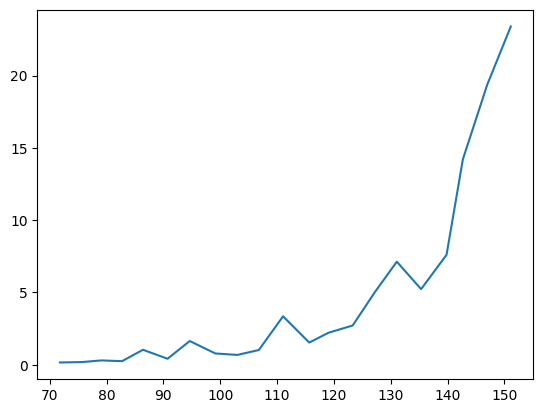

In [110]:
plt.plot([x[0]/math.log(2) for x in result],[x[1] for x in result])

In [134]:
a = numpy.array([1],numpy.float16)

In [135]:
a/=60

In [136]:
a*=240

In [137]:
a[0]==4.0

True

In [141]:
test_suite[6]

30867296940408863067133092791

In [181]:
test_suite = [2949231523384987, 20466659353807501, 93254413275320263, \
866688725164324243, 13537972160345845351, 115977360607903169239, \
793443526287967864007, 7056408368789625365561, \
35569861745979989719309, 362076874788268854825041, \
2521233717269282214688457, 27355976360013871507886869, \
183429252822965218567217171, 2101007139333211091223757589, \
7979642802875289184028692693, 74807084702215085036568661451, \
375074699507340783924576780139, 9372189180712719625159913892113, \
57293328714017015347205870646299, 315065796187959705133529122883371, \
2209303189892006576944231952711269, \
34408627518317733377056920903473519, \
232718028995839399213236584635085303, \
1348793990951317560486332634576401599, \
8114691958334431046469105095455478957, \
115266776040965760112876210916052935869, \
1110881110123544219852095069821953237023, \
8176822146066895507465396616355513022291, \
29765973637519321804466063622639108004309, \
368342294144456395762391067203366357755031, \
2858230333707645414359446882796534789311169, \
15981687373171234520579041061960854777396939, \
258192608923406027013804889622222229471673451, \
1136855377722422101625808553213959649966084531]

In [182]:
for i in test_suite:
    print(math.log(i)/math.log(2))

51.38926050597741
54.18412515758867
56.37202152088209
59.58829154967456
63.55364545807193
66.65240510890725
69.42668943997127
72.57942404765981
74.91307345442169
78.26064221977667
81.06040413889518
84.50005841993939
87.2453542016273
90.763139626332
92.68838272970288
95.91716156573897
98.24309270167947
102.88622892238844
105.49813810158061
107.95735217904551
110.7672185493146
114.72832557357778
117.48606630376199
120.02108142996221
122.609947745639
126.43824434292344
129.70690012398288
132.586735961269
134.45078788082466
138.08009895161416
141.03610216759097
143.51932781860958
147.53328387738475
149.67181300691144


In [189]:
def Test(factor, suite, fmin, fmax):
    result = []
    c1, c2 = 0, 0
    for i in suite:
        nlog = math.log(i) / math.log(2)
        if nlog < fmin:
            continue
        if nlog > fmax:
            break
        
        start = timer()
        res = factor(mpz(i))
        end = timer()
        time = (end - start)
        
        print(f"Factored: {i} -> {res}")
        
        c1 += 1
        
        if res != 1 and res != i:
            c2+=1
            result.append((nlog,time,res))
    return result, c2/c1

In [283]:
SIQS_Result = Test(lambda x:siqs2.factorize(x), test_suite, 80, 150)

Factored: 2521233717269282214688457 -> 1
Factored: 27355976360013871507886869 -> 4775061124829
Factored: 183429252822965218567217171 -> 13552799478467
Factored: 2101007139333211091223757589 -> 44581840388087
Factored: 7979642802875289184028692693 -> 86654193973961
Factored: 74807084702215085036568661451 -> 339017957045771
Factored: 375074699507340783924576780139 -> 588364452946043
Factored: 9372189180712719625159913892113 -> 2973197837689813
Factored: 57293328714017015347205870646299 -> 1
Factored: 315065796187959705133529122883371 -> 22842294082141409
Factored: 2209303189892006576944231952711269 -> 40605519529261013
Factored: 34408627518317733377056920903473519 -> 183977318913525421
Factored: 232718028995839399213236584635085303 -> 418265529909618299
Factored: 1348793990951317560486332634576401599 -> 1421063258621889269
Factored: 8114691958334431046469105095455478957 -> 2398386050083924469
Factored: 115266776040965760112876210916052935869 -> 9149999525527537997
Factored: 1110881110123

In [194]:
CFrac_Result = Test(lambda x:cfrac_factor(x), test_suite, 60, 120)

Factored: 13537972160345845351 -> 3360647149
Factored: 115977360607903169239 -> 10410534061
Factored: 793443526287967864007 -> 33580249657
Factored: 7056408368789625365561 -> 77219980469
Factored: 35569861745979989719309 -> 155772910207
Factored: 362076874788268854825041 -> 685955480663
Factored: 2521233717269282214688457 -> 1668443426789
Factored: 27355976360013871507886869 -> 4775061124829
Factored: 183429252822965218567217171 -> 13552799478467
Factored: 2101007139333211091223757589 -> 47126971902547
Factored: 7979642802875289184028692693 -> 92086054199213
Factored: 74807084702215085036568661451 -> 339017957045771
Factored: 375074699507340783924576780139 -> 588364452946043
Factored: 9372189180712719625159913892113 -> 2973197837689813
Factored: 57293328714017015347205870646299 -> 8408944635452611
Factored: 315065796187959705133529122883371 -> 13793089041537419
Factored: 2209303189892006576944231952711269 -> 54408937885893713
Factored: 34408627518317733377056920903473519 -> 18397731891

In [268]:
Rho_Result = Test(lambda x:pollard_rho(x), test_suite, 50, 88)

Factored: 2949231523384987 -> (mpz(49554601), 8447)
Factored: 20466659353807501 -> (mpz(113018051), 12313)
Factored: 93254413275320263 -> (mpz(344166593), 14938)
Factored: 866688725164324243 -> (mpz(831695261), 11845)
Factored: 13537972160345845351 -> (mpz(3360647149), 69764)
Factored: 115977360607903169239 -> (mpz(11140385299), 98745)
Factored: 793443526287967864007 -> (mpz(23628279551), 398457)
Factored: 7056408368789625365561 -> (mpz(77219980469), 145309)
Factored: 35569861745979989719309 -> (mpz(155772910207), 211174)
Factored: 362076874788268854825041 -> (mpz(685955480663), 1238907)
Factored: 2521233717269282214688457 -> (mpz(1668443426789), 570564)
Factored: 27355976360013871507886869 -> (mpz(5728926948761), 6188032)
Factored: 183429252822965218567217171 -> (mpz(13552799478467), 2788045)


In [266]:
ECM_Result = Test(ECM_Factor_WithParametrization, test_suite, 50, 100)

648 13388 23
used 1 curves
Factored: 2949231523384987 -> 59514787
764 17125 27
used 2 curves
Factored: 20466659353807501 -> 113018051
867 20689 30
used 0 curves
Factored: 93254413275320263 -> 344166593
1040 27168 34
used 7 curves
Factored: 866688725164324243 -> 1042074863
1293 37698 41
used 1 curves
Factored: 13537972160345845351 -> 4028382499
1528 48410 48
used 1 curves
Factored: 115977360607903169239 -> 10410534061
1769 60311 54
used 8 curves
Factored: 793443526287967864007 -> 23628279551
2084 77084 62
used 4 curves
Factored: 7056408368789625365561 -> 77219980469
2348 92173 68
used 17 curves
Factored: 35569861745979989719309 -> 228344335987
2778 118639 79
used 31 curves
Factored: 362076874788268854825041 -> 527843110807
3191 146020 89
used 19 curves
Factored: 2521233717269282214688457 -> 1668443426789
3772 187690 103
used 8 curves
Factored: 27355976360013871507886869 -> 5728926948761
4303 228629 115
used 12 curves
Factored: 183429252822965218567217171 -> 13534417971313
5080 293287 13

In [269]:
ECM_Result

([(51.38926050597741, 0.03630340006202459, mpz(59514787)),
  (54.18412515758867, 0.04750740004237741, mpz(113018051)),
  (56.37202152088209, 0.01403670001309365, mpz(344166593)),
  (59.58829154967456, 0.21607800002675503, mpz(1042074863)),
  (63.55364545807193, 0.043856299947947264, mpz(4028382499)),
  (66.65240510890725, 0.07855149998795241, mpz(10410534061)),
  (69.42668943997127, 0.458469899953343, mpz(23628279551)),
  (72.57942404765981, 0.29189829993993044, mpz(77219980469)),
  (74.91307345442169, 1.1930665000109002, mpz(228344335987)),
  (78.26064221977667, 2.6037214000243694, mpz(527843110807)),
  (81.06040413889518, 1.8526558000594378, mpz(1668443426789)),
  (84.50005841993939, 1.0024556999560446, mpz(5728926948761)),
  (87.2453542016273, 1.615613600006327, mpz(13534417971313)),
  (90.763139626332, 0.2143691999372095, mpz(44581840388087)),
  (92.68838272970288, 7.113267100066878, mpz(92086054199213)),
  (95.91716156573897, 11.21020710002631, mpz(339017957045771)),
  (98.2430927

In [274]:
def plot(result, name):
    plt.plot([x[0] for x in result[0]], [x[1] for x in result[0]], label=name)

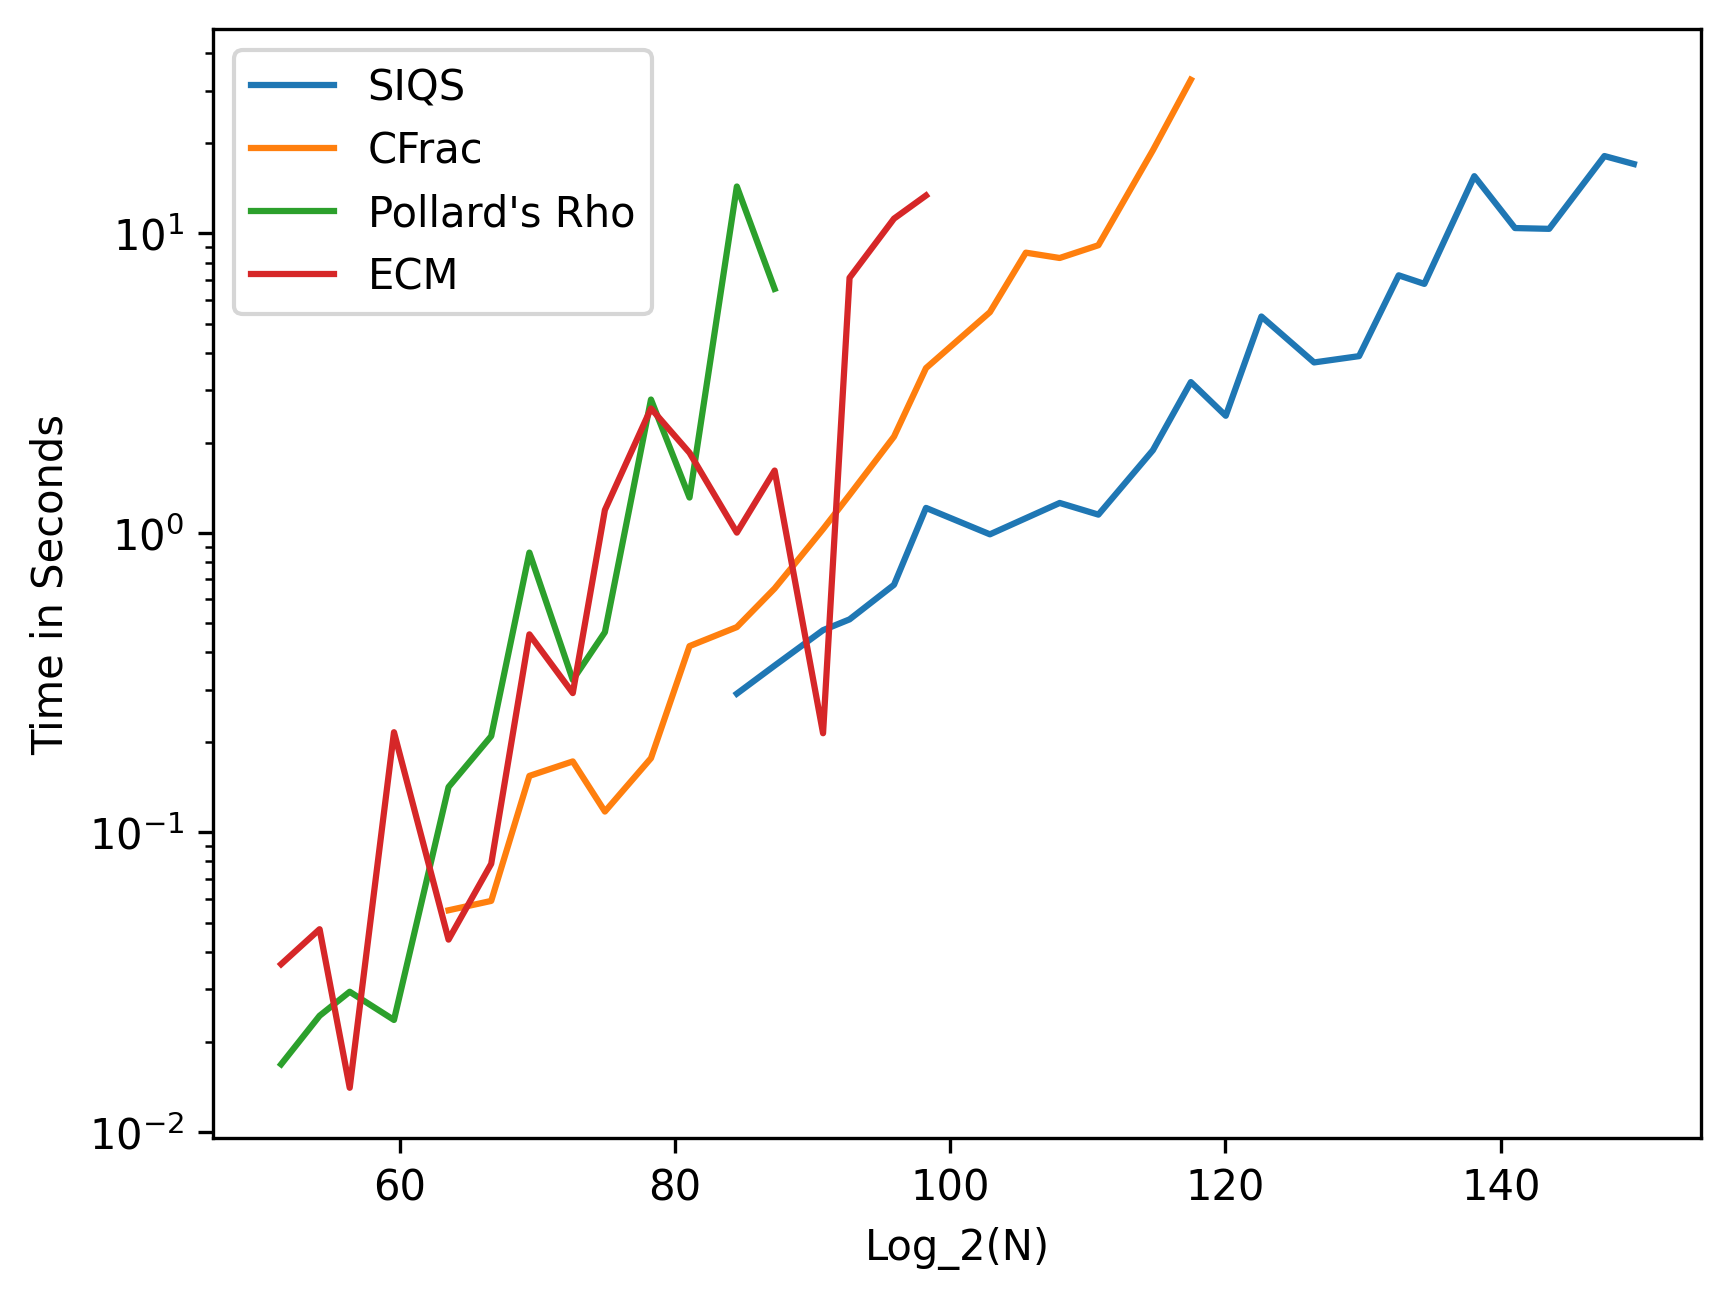

In [284]:
plt.figure(dpi=300)
plot(SIQS_Result, "SIQS")
plot(CFrac_Result, "CFrac")
plot(Rho_Result, "Pollard's Rho")
plot(ECM_Result, "ECM")
plt.yscale("log")
plt.xlabel("Log_2(N)")
plt.ylabel("Time in Seconds")
plt.legend()
plt.show()